## 大规模数据下的模型训练优化
## 项目：OutBrain广告CTR预估

竞赛背景

     #Outbrain Click Prediction#
     广告预估通常会面临超高的稀疏维度，以及超大量的训练数据。在计算资源受限的条件，如何保持训练效率和精度的平衡是CTR预估需要解决的一个主要问题。此数据集来源于Kaggle Outbrain Click Prediction竞赛。包含大量用户对于网页广告页面的点击，浏览以及广告发布人信息。给定对于页面的点击信息以及Context（上下文）相关信息，来对用户可能点击的广告页进行预测，从而达到推荐的目标。

> **提示：**类似于此部分的引用部分可以提供关于如何浏览和使用 iPython notebook 的实用说明。

# 开始
处理train和test数据集，通过将数去读取生成pandas dataframe，对数据做进一步的操作和和可视化分析
运行以下代码单元格，加载我们的数据并使用 `.head()` 函数显示前几个条目（乘客）以进行检查。
> **提示：**你可以通过点击单元格和使用键盘快捷键 **Shift + Enter** 或 **Shift + Return** 运行代码单元格。此外，在选中单元格后还可以使用工具栏中的**播放**按钮执行代码单元格。双击 Markdown 单元格（如下所示的文本单元格）即可进行编辑，并使用相同的快捷键保存。[Markdown](http://daringfireball.net/projects/markdown/syntax) 使你能够编写易于阅读的纯文本文件，这些文件可以转换为 HTML。

In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pylab as plt
import seaborn as sns
import gc
from csv import DictReader
from sklearn.model_selection import KFold

%matplotlib inline


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
path = "./"

# Any results you write to the current directory are saved as output.

## 数据的读取
* 由于数据量巨大，在线上notebook中可能无法全部加载并实现后续运算，因此此处可以选择加载少量数据进行测试
* 只使用500万行作为代码示例，有兴趣和充足计算资源可以下载完整数据并进行测试计算

In [29]:
## 读取数据
sample = True
if sample:
    reader = pd.read_csv(path+'clicks_train_5000000.csv',iterator=True,chunksize=5000000)
    df_train = next(reader)
else:
    df_train = pd.read_csv(path+'clicks_train_5000000.csv')

## 分别统计ad_id的个数，以及样本的数量
print('unique ad_id: %s'%df_train['ad_id'].nunique())
print('训练集共有%s条样本'%(df_train.shape[0]))

display_ids = df_train['display_id'].values.tolist()

if 'df_train_tr.csv' not in os.listdir(path):
    ## 切分数据集，缓存到硬盘中。供后续进行sgd训练
    kf = KFold(n_splits=5,random_state=42,shuffle=True).split(df_train.values)
    
    ind_tr,ind_te = next(kf)
    
    df_train_tr = df_train.iloc[ind_tr]
    df_train_val = df_train.iloc[ind_te]
    df_train_tr.to_csv(path+'df_train_tr.csv',index=False)
    df_train_val.to_csv(path+'df_train_val.csv',index=False)
    
    try:del df_train_tr,df_train_val # Being nice to Azure
    except:pass;gc.collect()
    

unique ad_id: 97078
训练集共有5000000条样本


## 数据的初步分析
* 数据字段的含义 [Outbrain CTR Prediction][1]
[1]: (https://www.kaggle.com/c/outbrain-click-prediction/data） "kaggle"

* 对于CTR数据，我们可以对其中相关的ad_id,display_id等字段信息进行观察，查看其稀疏程度，对于后续采用什么样的训练策略和特征工程策略有启发意义


### 问题0 统计在同一个display_id中出现广告的次数占总数据的比例
在进行训练之前，需要对数据进行一些分析，我们首先检验display_id的稀疏程度

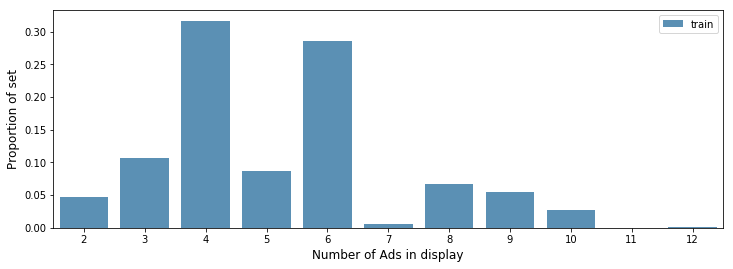

In [30]:
## 统计在同一个display_id中出现广告的次数占总数据的比例
sizes_train = df_train.groupby('display_id')['ad_id'].count().value_counts()
sizes_train = sizes_train / np.sum(sizes_train)

plt.figure(figsize=(12,4))

p = sns.color_palette()
sns.barplot(sizes_train.index, sizes_train.values, alpha=0.8, color=p[0], label='train')

plt.legend()
plt.xlabel('Number of Ads in display', fontsize=12)
plt.ylabel('Proportion of set', fontsize=12)

try:del sizes_train # Being nice to Azure
except:pass;gc.collect()


In [31]:
## 统计ad_id出现的次数

ad_unique_count = df_train['ad_id'].value_counts()

## 分别统计ad_id出现次数占比
for i in [2,5,10,50,200,500,1000]:
    print('Ads that appear less than {} times: {}%'.format(i, round((ad_unique_count < i).mean() * 100, 2)))

try:del df_train # Being nice to Azure
except:pass;gc.collect()

Ads that appear less than 2 times: 34.11%
Ads that appear less than 5 times: 57.96%
Ads that appear less than 10 times: 69.96%
Ads that appear less than 50 times: 87.08%
Ads that appear less than 200 times: 94.79%
Ads that appear less than 500 times: 97.76%
Ads that appear less than 1000 times: 99.02%


### 数据分析
events.csv包含用户的点击事件，包含了用户点击平台，事件，地点，点击的文档和用户id等信息
在这个notebook中，我们暂且不使用地点和时间信息进行特征工程
可行的特征工程方法包括：
* 提取时间年月日小时等
* 切分geo location，将国家，州，区块号划分出来构建特征

In [32]:
## 对event进行分析

try:del df_train # Being nice to Azure
except:pass;gc.collect()

events = pd.read_csv(path+'events_5000000.csv')
events = events[events['display_id'].isin(display_ids)]
print('Shape:', events.shape)
print('Columns', events.columns.tolist())
events.head()


('Shape:', (962999, 6))
('Columns', ['display_id', 'uuid', 'document_id', 'timestamp', 'platform', 'geo_location'])


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


统计document出现的次数


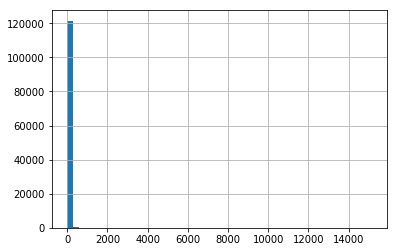

Documents that appear less than 2 times: 56.1%
Documents that appear less than 5 times: 82.29%
Documents that appear less than 10 times: 90.35%
Documents that appear less than 50 times: 97.8%
Documents that appear less than 200 times: 99.5%
Documents that appear less than 500 times: 99.86%
Documents that appear less than 1000 times: 99.94%



统计platform出现的次数
2     372171
1     370277
3      89479
2      61782
1      53016
3      16273
\N         1
Name: platform, dtype: int64


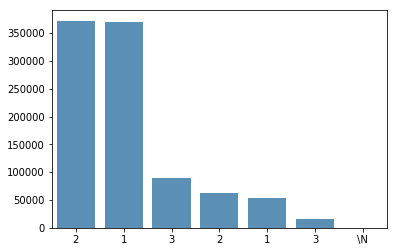

In [33]:
## 统计document出现的次数
print('统计document出现的次数')
document_unique_count = events['document_id'].value_counts()
document_unique_count.hist(bins=50)
plt.show()
## 分别统计ad_id出现次数占比
for i in [2,5,10,50,200,500,1000]:
    print('Documents that appear less than {} times: {}%'.format(i, round((document_unique_count < i).mean() * 100, 2)))

try:del document_unique_count # Being nice to Azure
except:pass;gc.collect()

## 统计platform出现的次数
print('')
print('')
print('')
print('统计platform出现的次数')
platform_unique_count = events['platform'].value_counts()
print(platform_unique_count)
sns.barplot(platform_unique_count.index, platform_unique_count.values, alpha=0.8, color=p[0])

try:del platform_unique_count # Being nice to Azure
except:pass;gc.collect()


In [34]:
## 对documents_topics进行分析
document_ids = events['document_id'].values.tolist()

try:del df_train,df_test # Being nice to Azure
except:pass;gc.collect()

documents_topics = pd.read_csv(path+'documents_topics.csv')
documents_topics = documents_topics[documents_topics['document_id'].isin(document_ids)]

print('Shape:', documents_topics.shape)
print('Columns', documents_topics.columns.tolist())
documents_topics.head()


('Shape:', (682432, 3))
('Columns', ['document_id', 'topic_id', 'confidence_level'])


,document_id,topic_id,confidence_level
16,1615583,89,0.316306
17,1615583,198,0.015722
20,1615354,84,0.096390
26,1614225,113,0.197576
27,1614225,260,0.136106


统计topic出现的次数
Topics that appear less than 10000 times: 97.67%
Topics that appear less than 20000 times: 100.0%
Topics that appear less than 50000 times: 100.0%
Topics that appear less than 100000 times: 100.0%


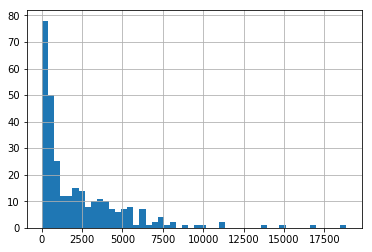

In [35]:
## 统计topic出现的次数
print('统计topic出现的次数')
topic_unique_count = documents_topics['topic_id'].value_counts()

topic_unique_count.hist(bins=50)

## 分别统计topic出现次数占比
for i in [10000,20000,50000,100000]:
    print('Topics that appear less than {} times: {}%'.format(i, round((topic_unique_count < i).mean() * 100, 2)))

try:del topic_unique_count # Being nice to Azure
except:pass;gc.collect()



In [36]:
## 对documents_meta.csv进行分析

try:del df_train,df_test # Being nice to Azure
except:pass;gc.collect()

documents_meta = pd.read_csv(path+'documents_meta.csv')
documents_meta = documents_meta[documents_meta['document_id'].isin(document_ids)]

print('Shape:', documents_meta.shape)
print('Columns', documents_meta.columns.tolist())
documents_meta.head()


('Shape:', (121859, 4))
('Columns', ['document_id', 'source_id', 'publisher_id', 'publish_time'])


,document_id,source_id,publisher_id,publish_time
3,1615583,1.0,603.0,2016-06-07 00:00:00
5,1615354,1.0,603.0,2016-06-10 00:00:00
8,1614225,1.0,603.0,2016-06-09 00:00:00
10,1614048,1.0,603.0,2016-06-05 12:00:00
17,1610319,1.0,603.0,2016-06-14 00:00:00


统计publisher_id出现的次数
Publishers that appear less than 10 times: 6.3%
Publishers that appear less than 50 times: 30.51%
Publishers that appear less than 200 times: 63.92%
Publishers that appear less than 1000 times: 91.53%
Publishers that appear less than 5000 times: 100.0%


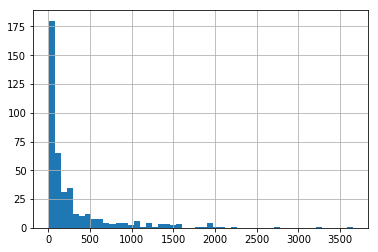

In [37]:
## 统计publisher_id出现的次数
print('统计publisher_id出现的次数')
publisher_unique_count = documents_meta['publisher_id'].value_counts()

publisher_unique_count.hist(bins=50)

## 分别统计publisher出现次数占比
for i in [10,50,200,1000,5000]:
    print('Publishers that appear less than {} times: {}%'.format(i, round((publisher_unique_count < i).mean() * 100, 2)))


    
try:del publisher_unique_count # Being nice to Azure
except:pass;gc.collect()


In [38]:
## 对documents_categories.csv进行分析

try:del df_train,df_test # Being nice to Azure
except:pass;gc.collect()

documents_categories = pd.read_csv(path+'documents_categories.csv')
documents_categories = documents_categories[documents_categories['document_id'].isin(document_ids)]

print('Shape:', documents_categories.shape)
print('Columns', documents_categories.columns.tolist())
documents_categories.head()


('Shape:', (233656, 3))
('Columns', ['document_id', 'category_id', 'confidence_level'])


,document_id,category_id,confidence_level
6,1615583,1305,0.920000
7,1615583,1806,0.070000
10,1615354,1608,0.505028
11,1615354,1807,0.038426
16,1614225,1608,0.920000


统计category出现的次数
Categories that appear less than 100 times: 12.22%
Categories that appear less than 1000 times: 43.33%
Categories that appear less than 5000 times: 87.78%
Categories that appear less than 20000 times: 97.78%
Categories that appear less than 100000 times: 100.0%


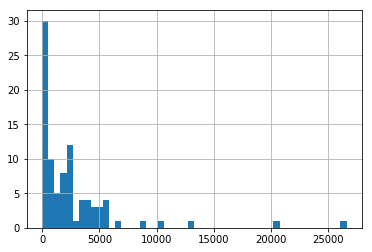

In [39]:
## 统计category出现的次数
print('统计category出现的次数')
category_unique_count = documents_categories['category_id'].value_counts()
category_unique_count.hist(bins=50)

## 分别统计category出现次数占比
for i in [100,1000,5000,20000,100000]:
    print('Categories that appear less than {} times: {}%'.format(i, round((category_unique_count < i).mean() * 100, 2)))

try:del category_unique_count # Being nice to Azure
except:pass;gc.collect()


In [40]:
## 对documents_entities.csv进行分析

try:del df_train,df_test # Being nice to Azure
except:pass;gc.collect()

documents_entities = pd.read_csv(path+'documents_entities.csv')
documents_entities = documents_entities[documents_entities['document_id'].isin(document_ids)]

print('Shape:', documents_entities.shape)
print('Columns', documents_entities.columns.tolist())
documents_entities.head()


('Shape:', (289752, 3))
('Columns', ['document_id', 'entity_id', 'confidence_level'])


,document_id,entity_id,confidence_level
14,1615583,9a934d9b311bf64b8648056653a70e61,0.293982
16,1615354,06ad429501daad2261e3895a83bbc0d4,0.238218
17,1615354,0e7946901ba0d126fa8f87edd9a68c92,0.234295
18,1615354,4a0a431aa637909de6bf1933e0e8641d,0.232917
19,1615354,b10ff56ecb5c347748052059dc0c8209,0.228253


统计entity出现的次数
Categories that appear less than 2 times: 76.08%
Categories that appear less than 5 times: 93.26%
Categories that appear less than 10 times: 97.09%
Categories that appear less than 30 times: 99.24%


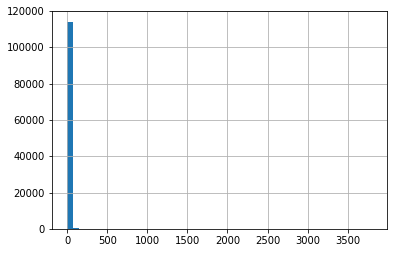

In [41]:
## 统计entity出现的次数
print('统计entity出现的次数')
entity_unique_count = documents_entities['entity_id'].value_counts()
entity_unique_count.hist(bins=50)

## 分别统计entity出现次数占比
for i in [2,5,10,30]:
    print('Categories that appear less than {} times: {}%'.format(i, round((entity_unique_count < i).mean() * 100, 2)))


try:del entity_unique_count # Being nice to Azure
except:pass;gc.collect()


In [42]:
## 对promoted_content.csv进行分析

try:del df_train,df_test # Being nice to Azure
except:pass;gc.collect()

promoted_content = pd.read_csv(path+'promoted_content.csv')
print('Shape:', promoted_content.shape)
print('Columns', promoted_content.columns.tolist())
promoted_content.head()


('Shape:', (559583, 4))
('Columns', ['ad_id', 'document_id', 'campaign_id', 'advertiser_id'])


,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7


## 什么是Hashing
在介绍hash trick之前，首先需要理解什么是hash table和hash操作
散列表（Hash table，也叫哈希表），是根据关键码值(Key value)而直接进行访问的数据结构。也就是说，它通过把关键码值映射到表中一个位置来访问记录，以加快查找的速度。这个映射函数叫做散列函数(hash function)，存放记录的数组叫做散列表。

我们基于一种结果尽可能随机平均分布的固定函数H为每个元素安排存储位置，这样就可以避免遍历性质的线性搜索，以达到快速存取。但是由于此随机性，也必然导致一个问题就是冲突。
所谓冲突，即两个元素通过散列函数H得到的地址相同，那么这两个元素称为“同义词”。这类似于70个人去一个有100个椅子的饭店吃饭。散列函数的计算结果是一个存储单位地址，每个存储单位称为“桶”。设一个散列表有m个桶，则散列函数的值域应为[0,m-1]。  

### hash trick的作用和计算方法
了解了hash操作后，在CTR预估以及一些大规模数据训练场景下，采用hash trick能够在不对数据提前进行预处理的情况下，直接生成稀疏输入进行训练
hash trick的效果类似onehot encoding,但相比onehot encoding需要提前计算类目特征的数量，确定需要映射的空间最大范围，hash trick可以不用关注映射的边界。如果训练过程中发现一些新增数据不曾出现在onehot的dictionary中，onehot encoding并没有特别好的方式对数据进行处理。因此hash trick对于线上大规模数据的训练就显得更加合适了。

### hash的计算

* 自己实现hash trick：
    hashed_index = abs((hash(f(key,value)) % D) 
* 其中D是需要散列的最大空间值,f(key,value)代表关于输入key和value的函数，用来结合两者，最简单的做法是作为str使用key+"_"+value的方式将两者结合起来

* 同时也可以采用sklearn相关接口 
提示：[Feature Hasher][1] 也相关方法可以参照sklearn文档以及其中的案例
[1]: (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html#sklearn.feature_extraction.FeatureHasher) "sklearn"


### 问题1 编写hash trick函数
* 通过编写hash trick函数，实现将原始类目样本映射到散列空间中去

In [43]:
def hash_trick(key,value,D=2**20):
    idx = abs(hash(key + '_' + value)) % D
    return idx
    

### 问题2.1 event特征工程
* 给定event dataframe和需要处理的特证名，购将特征dict，dict的形式为{"display_id_"+display_id:{"feature_name1":value,"feature_name2":value}}

In [44]:
## events to dict
event_dict = dict()
event_features = ['uuid','document_id','platform']
for idx,event in enumerate(events.to_dict('records')):
    if idx%200000==0:
        print('%s lines proccessed'%idx)
    
    event_dict['display_id_%s'%event['display_id']] = dict()
    for k in event_features:
        event_dict['display_id_%s'%event['display_id']][k] = event[k]
    

0 lines proccessed
200000 lines proccessed
400000 lines proccessed
600000 lines proccessed
800000 lines proccessed


### 问题2.2 document特征工程
* 给定document相关dataframe和需要处理的特证名，购将特征dict，dict的形式为{"document\_id\_"+document_id:{"feature_name1":value,"feature_name2":value}}

In [45]:

def get_document_dict(df,features= ['source_id', 'publisher_id']):
    documents_dict = dict()
    for idx,dm in enumerate(df.to_dict('records')):
        if idx%50000==0:
            print('%s lines proccessed'%idx)
        documents_dict['document_id_%s'%dm['document_id']] = dict()
        for k in features:
            documents_dict['document_id_%s'%dm['document_id']][k] = dm[k]
    return documents_dict


## document_meta to dict
documents_meta_features = ['source_id', 'publisher_id']
documents_meta_dict = get_document_dict(documents_meta,features=documents_meta_features)

print('')
print('')

## documents_topics to dict
documents_topics_features = ['topic_id']
documents_topics_dict = get_document_dict(documents_topics,features=documents_topics_features)


print('')
print('')

## documents_entities to dict
documents_entities_features = ['entity_id']
documents_entities_dict = get_document_dict(documents_entities,features=documents_entities_features)

print('')
print('')

## documents_categories to dict
documents_categories_features = ['category_id']
documents_categories_dict = get_document_dict(documents_categories,features=documents_categories_features)


0 lines proccessed
50000 lines proccessed
100000 lines proccessed


0 lines proccessed
50000 lines proccessed
100000 lines proccessed
150000 lines proccessed
200000 lines proccessed
250000 lines proccessed
300000 lines proccessed
350000 lines proccessed
400000 lines proccessed
450000 lines proccessed
500000 lines proccessed
550000 lines proccessed
600000 lines proccessed
650000 lines proccessed


0 lines proccessed
50000 lines proccessed
100000 lines proccessed
150000 lines proccessed
200000 lines proccessed
250000 lines proccessed


0 lines proccessed
50000 lines proccessed
100000 lines proccessed
150000 lines proccessed
200000 lines proccessed


# Factorization Machine(FM模型)

无论是用线性回归进行回归预测，还是使用逻辑回归进行分类预测，广义线性模型族通常只能够处理线性可分的数据集，而我们在解决CTR问题的过程中，实际接触到的数据绝大部分存在非线性关系。而采用SVM，NN，GBDT等算法进行非线性算法或多或少都存在数据量过大，计算资源不足够支撑这些算法的情况存在。因此如果在线性的时间复杂度内，完成一个模型的非线性特征拟合，催生出了FM模型以及其后续FFM模型的产生。
通常情况下，能够对广义线性模型进行非线性特征拟合能力增强的方法有如下措施：

    1.核函数方法或者隐层+激活函数，将非线性数据集映射到高维空间中，使其近似线性可分（相当于改造成SVM和NN）
    2.多项式回归，认为构造特征的多级交互
    3.FM模型，对线性模型的部分进行扩展。在保留线性部分的同时，增加非线性的隐向量（latent vector），近似二阶（或者更高，但是计算效率会随着order的提高而变差）多项式回归


### 多项式模型存在的问题

在很长一段时间内，多项式回归因其高效的训练方式（online learning）和对于hash trick的良好兼容，作为业界解决方案而被广泛采用

然而多项式模型也存在一定的问题

先从线性回归和多项式回归开始建模，这里我们以二阶多项式模型（degree = 2时）为例：

$\hat{y}(x) := \underbrace {w_0 + \sum_{i=1}^{n} w_i x_i }_{\text{线性回归}} + \underbrace {\sum_{i=1}^{n} \sum_{j=i+1}^{n} w_{ij} x_i x_j}_{\text{交叉项（组合特征）}}$

n 代表样本的特征数量，$xi$是第 i 个特征的值，$w0$、$wi$、$wij$是模型参数。由于对数据进行了2阶组合，在线性部分外，组合特征一共有n(n-1)/2个，也将对应生成n(n-1)/2 模型系数，其算法的时间复杂度变为$O(n^2)$,当n为一个很大的数字时，会造成两个问题：
* 数据过于稀疏，特征维度很有可能远远高于样本量，很大概率造成过拟合，需要增加更强的正则
* 增加训练和存储模型参数所需要的运算资源和存储资源

### 利用FM模型解决这类问题
Steffen Rendle于2010年提出了Factorization Machines(FM) ，相对于其他非线性模型，FM模型存在以下优势

    1.FM可以实现对于输入数据是非常稀疏（比如自动推荐系统），而SVM会效果很差，因为训出的SVM模型会面临较高的bias。
    2.FM拥有线性的复杂度

FM模型中认为
所有二次项参数 $w_{ij}$ 可以组成一个对称阵 $W$，可以分解为$W=V^TV$，$V$ 的第 j 列便是第 j 维特征的隐向量，也就是说每个参数 $w_{ij}=⟨v_i,v_j⟩w_{ij}=⟨v_i,v_j⟩$ ，这就是FM模型的核心思想（不讨论高阶形式）。

所以可以得到： 
$\hat{y}(\mathbf{x}) := w_0 + \sum_{i=1}^{n} w_i x_i + \sum_{i=1}^{n} \sum_{j=i+1}^{n} \langle \mathbf{v}_i, \mathbf{v}_j \rangle x_i x_j$

##### FM的化简
此时原始模型算法复杂度依然为$O(n^2)$，不过我们通过化简trick得到：
$\sum_{i=1}^n \sum_{j=i+1}^n \langle \mathbf{v}_i, \mathbf{v}_j \rangle x_i x_j = \frac{1}{2} \sum_{f=1}^k \left(\left( \sum_{i=1}^n v_{i, f} x_i \right)^2 - \sum_{i=1}^n v_{i, f}^2 x_i^2 \right)$



## 问题3 一些FM模型需要的函数
* 3.1 矩阵的点击计算
* 3.2 exponential loss函数$ln(1+exp(-y*p))$

In [46]:
def dot(u,v):
    u_v = 0
    len_u = len(u)
    for idx in range(len_u):
        uu = u[idx]
        vv = v[idx]
        u_v+=uu*vv
    return u_v


def exponential_loss_function(y,p):
    return log(1+exp(-y*p))



## 构建模型的数据加载器
为了让模型使用随机梯度下降算法，我们可以构建一个数据加载器，从硬盘中逐行读取数据，配合我们先前构建的特征dict来实现特征的结合
此处我们最终实现的是对特征的逐条生成，并且输入模型中，使用Adam——一种优化过的自适应梯度下降算法


In [47]:
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt,pow
import itertools
import math
from random import random,shuffle,uniform,seed
import pickle
import sys

seed(1024)

def data_generator(path,no_norm=False,task='c',D=2**20):
    for t, row in enumerate(DictReader(open(path), delimiter=',')):
        # process id
        
        try:
            ID=row['display_id']
            del row['display_id']
        except:
            pass
        
        # process clicks
        y = 0.
        target='clicked'#'IsClick' 
        if target in row:
            if row[target] == '1':
                y = 1.
            del row[target]

        # build x
        x = []
        for key in row:
            value = row[key]
            
            # one-hot encode everything with hash trick
            idx = hash_trick(key,value,D)
            x.append([idx,1.0])
        
        ## events features
        events = event_dict['display_id_%s'%ID]
        document_id = events['document_id']
        for key in event:
            value = event[key]
            # one-hot encode everything with hash trick
            idx = hash_trick(str(key),str(value),D)
            x.append([idx,1.0])
        
        ## document meta feature
        documents_meta = documents_meta_dict.get('document_id_%s'%document_id,{})
        for key in documents_meta:
            value = documents_meta[key]
            # one-hot encode everything with hash trick
            idx = hash_trick(str(key),str(value),D)
            x.append([idx,1.0])
            
            
        ## document topic features
        documents_topic = documents_topics_dict.get('document_id_%s'%document_id,{})
        for key in documents_topic:
            value = documents_topic[key]
            # one-hot encode everything with hash trick
            idx = hash_trick(str(key),str(value),D)
            x.append([idx,1.0])
            
        ## documents_entity features
        documents_entities = documents_entities_dict.get('document_id_%s'%document_id,{})
        for key in documents_entities:
            value = documents_entities[key]
            # one-hot encode everything with hash trick
            idx = hash_trick(str(key),str(value),D)
            x.append([idx,1.0])
            
        ## documents_categories features
        documents_categories = documents_categories_dict.get('document_id_%s'%document_id,{})
        for key in documents_categories:
            value = documents_categories[key]
            # one-hot encode everything with hash trick
            idx = hash_trick(str(key),str(value),D)
            x.append([idx,1.0])
        
        
        ## l2 row-wise normalization
        if not no_norm:
            r = 0.0
            for i in range(len(x)):
                r+=x[i][1]*x[i][1]
            for i in range(len(x)):
                x[i][1] /=r
                
        if task=='c':
            if y ==0.0:
                y = -1.0
                
        yield x,y


In [48]:

def mse_loss_function(y,p):
    return (y - p)**2

class FM(object):
    def __init__(self,lr=0.001,momentum=0.9,nesterov=True,adam=False,l2=0.0,l2_fm=0.0,l2_bias=0.0,ini_stdev= 0.01,dropout=0.5,task='c',n_components=4,nb_epoch=5,interaction=False,no_norm=False,D=2**20,verbose=True):
        self.W = []
        self.V = []        
        self.bias = uniform(-ini_stdev, ini_stdev)
        self.n_components=n_components
        self.lr = lr
        self.l2 = l2
        self.l2_fm = l2_fm
        self.l2_bias = l2_bias
        self.momentum = momentum
        self.nesterov = nesterov
        self.adam = adam
        self.nb_epoch = nb_epoch
        self.ini_stdev = ini_stdev
        self.task = task
        self.interaction = interaction
        self.dropout = dropout
        self.no_norm = no_norm
        self.D = D
        self.verbose=verbose
        if self.task!='c':
            self.loss_function = mse_loss_function
        else:
            self.loss_function = exponential_loss_function
        self.preload()
        if adam:
            self.adam_init()
        
        
    def preload(self):
        dim = self.D
        print("Number of features:",dim)

        self.W = [uniform(-self.ini_stdev, self.ini_stdev) for _ in range(dim)]
        self.Velocity_W = [0.0 for _ in range(dim)]
        

        self.V = [[uniform(-self.ini_stdev, self.ini_stdev) for _ in range(self.n_components)] for _ in range(dim)]
        self.Velocity_V = [[0.0 for _ in range(self.n_components)] for _ in range(dim)]

        self.Velocity_bias = 0.0

        self.dim = dim


    def adam_init(self):
        self.iterations = 0
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.epsilon=1e-8
        self.decay = 0.
        self.inital_decay = self.decay 

        dim =self.dim

        self.m_W = [0.0 for _ in range(dim)]
        self.v_W = [0.0 for _ in range(dim)]

        self.m_V = [[0.0 for _ in range(self.n_components)] for _ in range(dim)]
        self.v_V = [[0.0 for _ in range(self.n_components)] for _ in range(dim)]

        self.m_bias = 0.0
        self.v_bias = 0.0


    def adam_update(self,lr,x,residual):

        if 0.<self.dropout<1.:
            self.droupout_x(x)
        
        lr = self.lr
        if self.inital_decay > 0:
            lr *= (1. / (1. + self.decay * self.iterations))

        t = self.iterations + 1

        lr_t = lr * sqrt(1. - pow(self.beta_2, t)) / (1. - pow(self.beta_1, t))
        
        for sample in x:
            idx,value = sample
            g = residual*value

            m = self.m_W[idx]
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g

            v = self.v_W[idx]
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * (g**2)

            p = self.W[idx]
            p_t = p - lr_t *m_t / (sqrt(v_t) + self.epsilon)

            if self.l2>0:
                pt = pt - lr_t*self.l2*p

            self.m_W[idx] = m_t
            self.v_W[idx] = v_t
            self.W[idx] = p_t

        if self.interaction:
            self._adam_update_fm(lr_t,x,residual)


        m = self.m_bias
        m_t = (self.beta_1 * m) + (1. - self.beta_1)*residual

        v = self.v_bias
        v_t = (self.beta_2 * v) + (1. - self.beta_2)*(residual**2)

        p = self.bias
        p_t = p - lr_t * m_t / (sqrt(v_t) + self.epsilon)
        if self.l2_bias>0:
            pt = pt - lr_t * self.l2_bias*p

        self.m_bias = m_t
        self.v_bias = v_t
        self.bias = p_t

        self.iterations+=1

    def _adam_update_fm(self,lr_t,x,residual):
        len_x = len(x)
        sum_f_dict = self.sum_f_dict
        n_components = self.n_components
        for f in range(n_components):
            for i in range(len_x):
                idx_i,value_i = x[i]
                v = self.V[idx_i][f]
                sum_f = sum_f_dict[f]
                g = (sum_f*value_i - v *value_i*value_i)*residual

                m = self.m_V[idx_i][f]
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * g

                v = self.v_V[idx_i][f]
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * (g**2)

                p = self.V[idx_i][f]
                p_t = p - lr_t * m_t / (sqrt(v_t) + self.epsilon)

                if self.l2_fm>0:
                    pt = pt - lr_t * self.l2_fm*p

                self.m_V[idx_i][f] = m_t
                self.v_V[idx_i][f] = v_t
                self.V[idx_i][f] = p_t

    def droupout_x(self,x):
        new_x = []
        for i, var in enumerate(x):
            if random() > self.dropout:
                del x[i]

    def _predict_fm(self,x):
        len_x = len(x)
        n_components = self.n_components
        pred = 0.0
        self.sum_f_dict = {}
        for f in range(n_components):
            sum_f = 0.0
            sum_sqr_f = 0.0
            for i in range(len_x):
                idx_i,value_i = x[i]
                d = self.V[idx_i][f] * value_i
                sum_f +=d
                sum_sqr_f +=d*d
            pred+= 0.5 * (sum_f*sum_f - sum_sqr_f);
            self.sum_f_dict[f] = sum_f
        return pred

    def _predict_one(self,x):
        pred = self.bias
        # pred = 0.0
        for idx,value in x:
            pred+=self.W[idx]*value
        
        if self.interaction:
            pred+=self._predict_fm(x)
        
        return pred


    def _update_fm(self,lr,x,residual):
        len_x = len(x)
        sum_f_dict = self.sum_f_dict
        n_components = self.n_components
        for f in range(n_components):
            for i in range(len_x):
                idx_i,value_i = x[i]
                sum_f = sum_f_dict[f]
                v = self.V[idx_i][f]
                grad = (sum_f*value_i - v *value_i*value_i)*residual
                
                self.Velocity_V[idx_i][f] = self.momentum * self.Velocity_V[idx_i][f] - lr * grad
                if self.nesterov:
                    self.Velocity_V[idx_i][f] = self.momentum * self.Velocity_V[idx_i][f] - lr * grad
                self.V[idx_i][f] = self.V[idx_i][f] + self.Velocity_V[idx_i][f] - self.l2_fm*self.V[idx_i][f]



    def update(self,lr,x,residual):

        if 0.<self.dropout<1.:
            self.droupout_x(x)

        for sample in x:
            idx,value = sample
            grad = residual*value
            self.Velocity_W[idx] =  self.momentum * self.Velocity_W[idx] - lr * grad
            if self.nesterov:
                 self.Velocity_W[idx] = self.momentum * self.Velocity_W[idx] - lr * grad
            self.W[idx] = self.W[idx] + self.Velocity_W[idx] - self.l2*self.W[idx]
            
        if self.interaction:
            self._update_fm(lr,x,residual)

        self.Velocity_bias = self.momentum*self.Velocity_bias - lr*residual
        if self.nesterov:
            self.Velocity_bias = self.momentum*self.Velocity_bias - lr*residual
        self.bias = self.bias +self.Velocity_bias - self.l2_bias*self.bias

    def predict(self,path,out):

        data = data_generator(path,self.no_norm,self.task,self.D)
        y_preds =[]
        with open(out, 'w') as outfile:
            ID = 0
            outfile.write('%s,%s\n' % ('ID', 'target'))
            for d in data:
                x,y = d
                p = self._predict_one(x)
                outfile.write('%s,%s\n' % (ID, str(p)))
                ID+=1


    def validate(self,path):
        data = data_generator(path,self.no_norm,self.task,self.D)
        loss = 0.0
        count = 0.0

        for d in data:
            x,y = d
            p = self._predict_one(x)
            loss+=self.loss_function(y,p)
            count+=1
        return loss/count

    def save_weights(self):
        weights = []
        weights.append(self.W)
        weights.append(self.V)
        weights.append(self.bias)
        weights.append(self.Velocity_W)
        weights.append(self.Velocity_V)
        weights.append(self.dim)
        pickle.dump(weights,open('sgd_fm.pkl','wb'))

    def load_weights(self):
        weights = pickle.load(open('sgd_fm.pkl','rb'))
        self.W = weights[0]
        self.V = weights[1]
        self.bias = weights[2]
        self.Velocity_W = weights[3]
        self.Velocity_V = weights[4]
        self.dim = weights[5]
        

    def train(self,path,valid_path = None,in_memory=False):

        start = datetime.now()
        lr = self.lr
        if self.adam:
            self.adam_init()
            self.update = self.adam_update

        if in_memory:
            data = data_generator(path,self.no_norm,self.task,self.D)
            data = [d for d in data]
        best_loss = 999999
        best_epoch = 0
        for epoch in range(1,self.nb_epoch+1):
            if not in_memory:
                data = data_generator(path,self.no_norm,self.task,self.D)
            train_loss = 0.0
            train_count = 0
            for x,y in data:
                p = self._predict_one(x)
                if self.task!='c':                    
                    residual = -(y-p)
                else:
                    residual = -y*(1.0-1.0/(1.0+exp(-y*p)));
                    # residual = -(y-p)

                self.update(lr,x,residual)
                if self.verbose>0:
                    if self.verbose==True:
                        self.verbose = 50000
                    if train_count%self.verbose==0:
                        if train_count ==0:
                            print('\ttrain_count: %s, current loss: %.6f'%(train_count,0.0))
                        else:
                            print('\ttrain_count: %s, current loss: %.6f'%(train_count,train_loss/train_count))
                
                train_loss += self.loss_function(y,p)
                train_count += 1

            epoch_end = datetime.now()
            duration = epoch_end-start
            
            if valid_path:
                valid_loss = self.validate(valid_path)
                print('Epoch: %s, train loss: %.6f, valid loss: %.6f, time: %s'%(epoch,train_loss/train_count,valid_loss,duration))
                if valid_loss<best_loss:
                    best_loss = valid_loss
                    print('save_weights')
            else:

                print('Epoch: %s, train loss: %.6f, time: %s'%(epoch,train_loss/train_count,duration))

## FM模型与线性模型效果对比

由于FM是在线性算法的基础上增加了非线性隐变量代码，因此我们可以很方便的在代码中控制模型表现为线性模型还是FM模型
通过interaction设置为False，模型将自动退化为逻辑回归

我们使用同样的配置来进行模型的训练，以此来对比模型的效果

    *首先是线性模型，我们使用hash trick将所有特征映射到一个2**18的向量空间中

In [49]:
try:del fm,df_train,df_test
except:pass;gc.collect()

fm = FM(lr=0.001,adam=True,nesterov=True,task='c',nb_epoch=1,interaction=False,no_norm=False,D=2**18,verbose=1000000)
fm.train(path+'df_train_tr.csv',path+'df_train_val.csv',in_memory=False)
fm.predict(path+'df_train_val.csv',out=path+'valid.csv')


('Number of features:', 262144)
	train_count: 0, current loss: 0.000000
	train_count: 1000000, current loss: 0.490127
	train_count: 2000000, current loss: 0.486971
	train_count: 3000000, current loss: 0.483918
Epoch: 1, train loss: 0.481131, valid loss: 0.478290, time: 0:03:13.257470
save_weights


    *FM模型interaction=True，我们通过设置n_components=2，赋予模型隐变量维度K为2

In [50]:
try:del fm
except:pass;gc.collect()

fm = FM(lr=0.001,adam=True,nesterov=True,task='c',n_components=2,nb_epoch=1,interaction=True,no_norm=False,D=2**18,verbose=1000000)
fm.train(path+'df_train_tr.csv',path+'df_train_val.csv',in_memory=False)
fm.predict(path+'df_train_val.csv',out=path+'valid.csv')

('Number of features:', 262144)
	train_count: 0, current loss: 0.000000
	train_count: 1000000, current loss: 0.484763
	train_count: 2000000, current loss: 0.479138
	train_count: 3000000, current loss: 0.474191
Epoch: 1, train loss: 0.469761, valid loss: 0.462023, time: 0:06:05.073566
save_weights


我们可以看到，使用FM模型在验证的精度上大幅超过了逻辑回归的效果，同时训练速度基本上还维持在线性的时间复杂度上，证明我们采用FM模型是一种行之有效的方法

## 总结
CTR相关任务通常涉及海量的数据，高维且稀疏的特征集。如果选择更好的训练策略，模型，特征工程方式将会极大的影响训练效率和精度的平衡。
如今CTR的发展也变得更加多样，在一些大型企业中也会采用深度学习的方式，如DeepFM模型，Wide And Deep Neural Network等。但是原则上都会在训练效率和精度上取得一个平衡点，并且需要根据企业自身的资源和能力，进行适当的调节。